## Data

The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models).

We are to consider possible differences in miles/gallon (mpg) in some control groups like number of cylinders. 

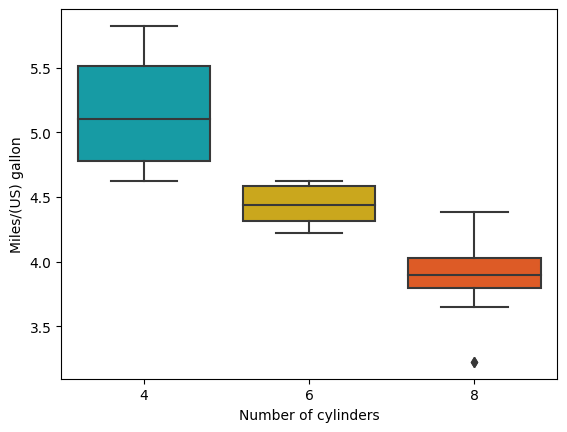

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the mtcars dataset

url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Create a box plot
sns.boxplot(x='cyl', y='mpg', data=mtcars, palette=["#00AFBB", "#E7B800", "#FC4E07"], order=["4", "6", "8"])

# Add axis labels
plt.xlabel("Number of cylinders")
plt.ylabel("Miles/(US) gallon")

# Show the plot
plt.show()

Let's take a look at confidence intervals first.

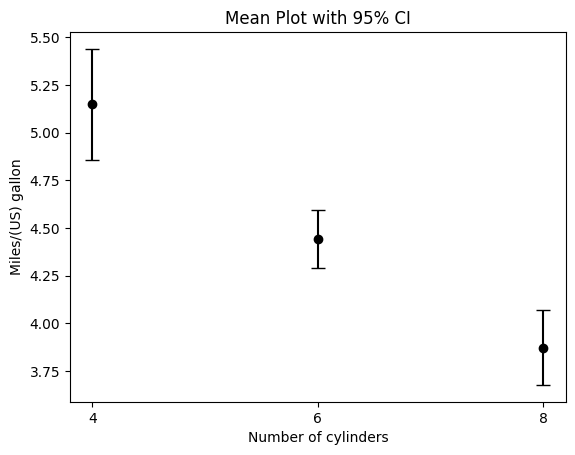

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Calculate means and confidence intervals
means = mtcars.groupby('cyl')['mpg'].mean()
conf_intervals = mtcars.groupby('cyl')['mpg'].apply(lambda x: DescrStatsW(x).tconfint_mean())

# Extract lower and upper bounds of the confidence intervals
lower_bounds = conf_intervals.apply(lambda x: x[0])
upper_bounds = conf_intervals.apply(lambda x: x[1])

# Create the plot
plt.errorbar(means.index, means, yerr=[means - lower_bounds, upper_bounds - means], fmt='o', capsize=5, color='black')
plt.xlabel("Number of cylinders")
plt.ylabel("Miles/(US) gallon")
plt.title("Mean Plot with 95% CI")

# Show the plot
plt.show()

## 1-way Anova

We want to know if there is any significant difference between the average miles/gallon usage in the 3 different types of cars (with 3 different numbers of cylinders).

Let's start with normality check-up.

In [8]:
import pandas as pd
from scipy.stats import shapiro

# Group by 'cyl' and apply the Shapiro-Wilk test for normality on 'mpg'
shapiro_results = mtcars.groupby('cyl')['mpg'].apply(lambda x: shapiro(x))

# Create a DataFrame to display the results
shapiro_df = pd.DataFrame({
    'cyl': shapiro_results.index,
    'W': [result[0] for result in shapiro_results],
    'p-value': [result[1] for result in shapiro_results]
})

print(shapiro_df)

  cyl         W   p-value
0   4  0.915339  0.281708
1   6  0.898284  0.320718
2   8  0.915158  0.187208


We can also observe normality qq plots together with Shapiro-Wilk results (above):

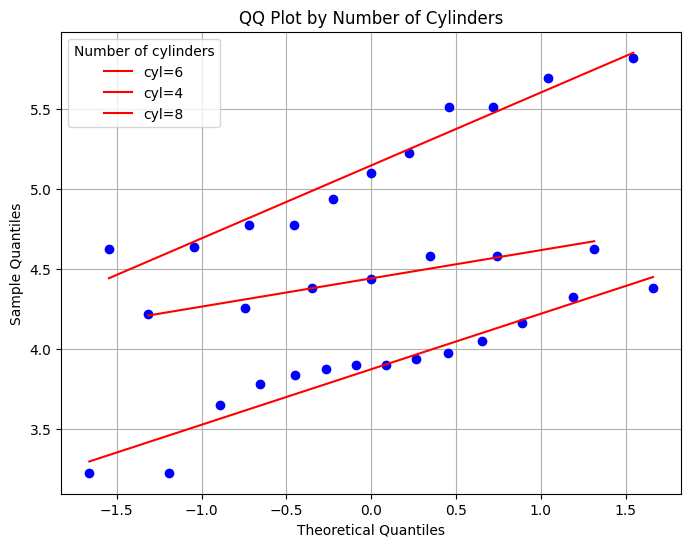

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a QQ plot with QQ line
plt.figure(figsize=(8, 6))
for cyl in mtcars['cyl'].unique():
    subset = mtcars[mtcars['cyl'] == cyl]
    stats.probplot(subset['mpg'], dist="norm", plot=plt)
    plt.gca().get_lines()[-1].set_label(f'cyl={cyl}')

plt.legend(title='Number of cylinders')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot by Number of Cylinders')
plt.grid(True)
plt.show()

We cannot see any deviations from normality line, p-values also suggest no rejection. 

Next, let's test the assumption about the homogeneity of variances. I highly recommend Levene’s test, which is less sensitive to departures from normal distribution. 

In [ ]:
import pandas as pd
from scipy.stats import levene

# Load the mtcars dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Perform Levene's test for equal variances
stat, p_value = levene(mtcars[mtcars['cyl'] == '4']['mpg'],
                       mtcars[mtcars['cyl'] == '6']['mpg'],
                       mtcars[mtcars['cyl'] == '8']['mpg'])

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 2.868889131775262
p-value: 0.07296950644913475


P-value is only a little bit higher than our threshold alpha=0.05, so if you would like to run more robust Anova => Welch's Anova, run the function from pingouin library:

*welch_anova_results = pg.welch_anova(dv='mpg', between='cyl', data=mtcars)*

## Finally, let's calculate the ANOVA table (with equal variances):

In [18]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('mpg ~ cyl', data=mtcars).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_results)

             sum_sq    df          F        PR(>F)
cyl       10.013559   2.0  41.055426  3.477779e-09
Residual   3.536600  29.0        NaN           NaN


## As we can see, at least one pair of means is significantly different (H0 should be rejected). It means that miles per gallon significantly differs in cars with different number of cylinders. 

Now, in case of H0 rejection, we can perform the post-hoc LSD (least-significant-differences) or HSD (honestly-significant-differences) tests. Tukey HSD, used to compare all groups to each other (so all possible comparisons of 2 groups).

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


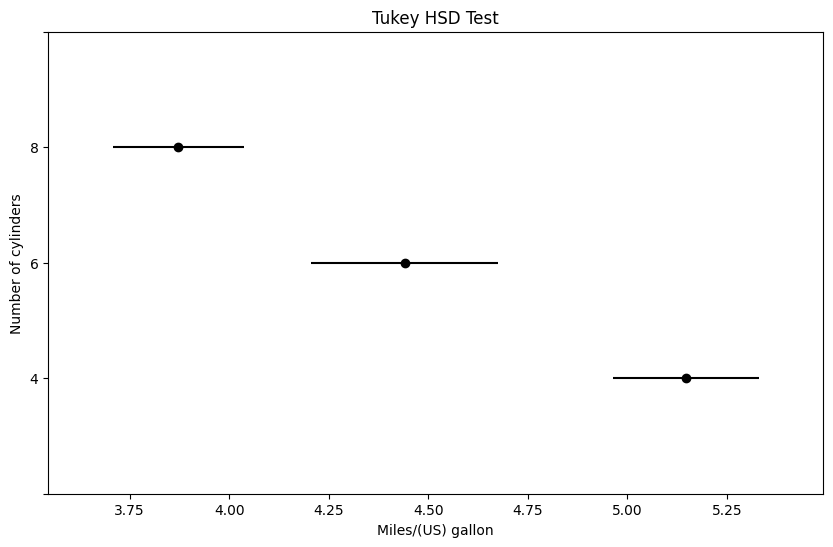

In [20]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Print the results
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test')
plt.xlabel('Miles/(US) gallon')
plt.ylabel('Number of cylinders')
plt.show()

## As we can see above, all pairs of means are significantly different (p<alfa).

Finally, let's visualize our results together with Anova test and its post-hoc tests:

Text(0.5, 0.95, 'ANOVA F-value: 41.06\nANOVA p-value: 0.000')

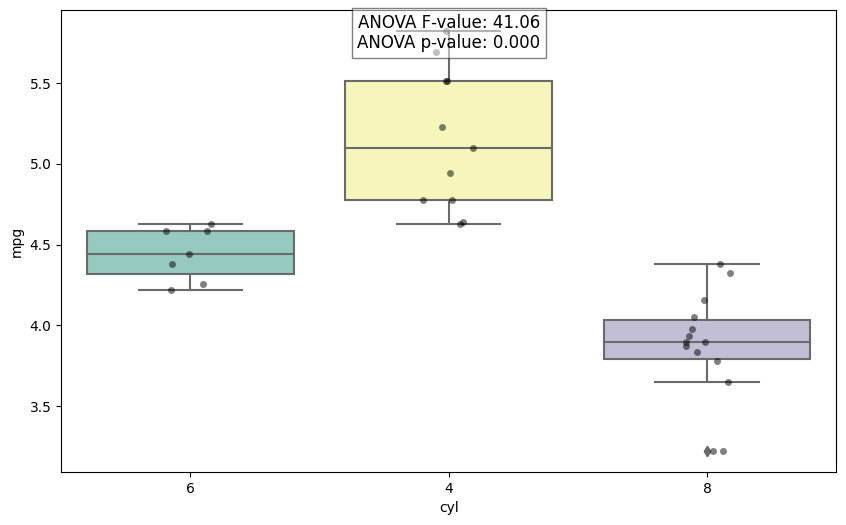

In [25]:
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Plot the results using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='cyl', y='mpg', data=mtcars, palette="Set3")
sns.stripplot(x='cyl', y='mpg', data=mtcars, color='black', jitter=True, alpha=0.5)

# Annotate the plot with ANOVA results
anova_text = (f"ANOVA F-value: {anova_results['F'][0]:.2f}\n"
              f"ANOVA p-value: {anova_results['PR(>F)'][0]:.3f}")
plt.text(0.5, 0.95, anova_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

DIY: 

What about **am, number of gears**? 

In [ ]:
# your code goes here

# Your turn!

The following dataset contains the job satisfaction score organized by gender and education level.

In this study, a researcher wants to evaluate if there is a significant two-way interaction between gender and education_level on explaining the job satisfaction score.

An **interaction effect** occurs when the effect of one independent variable on an outcome variable depends on the level of the other independent variables. If an interaction effect does not exist, main effects could be reported.



In [4]:
import pandas as pd

# Load the jobsatisfaction dataset from my github repo:
url = "https://raw.githubusercontent.com/kflisikowski/ds/master/jobsatisfaction.csv"
jobsatisfaction = pd.read_csv(url)